In [1]:
# MovieLens Ising Model Analysis - Clean Version
# CS179 Final Project

# Import all our custom modules
import sys
sys.path.append('../src/')

from data_preprocessing import preprocessing_pipeline
from ising_model import learn_ising_structure, select_best_model, analyze_dependencies
from evaluation import create_missing_data_test, compare_methods, statistical_comparison, print_evaluation_summary
from visualization import create_summary_plots

import numpy as np
import pandas as pd


In [2]:
# ============================================================================
# 1. DATA PREPROCESSING
# ============================================================================

print("Starting MovieLens Ising Model Analysis")
print("="*60)

# Run complete preprocessing pipeline
data = preprocessing_pipeline(
    data_path='../data/ml-latest-small/',
    min_user_ratings=50,
    min_movie_ratings=20, 
    binary_threshold=4.0,
    n_movies=50,
    n_users=100
)

# Extract key variables
X_ising = data['X_ising']
movie_titles = data['movie_titles']
movies_df = data['movies_df']

# Calculate movie popularity for baselines
pXi = np.mean(X_ising, axis=0)

print(f"\nTop 10 most liked movies:")
sorted_prefs = [(i, movie_titles[i], pXi[i]) for i in range(len(pXi))]
sorted_prefs.sort(key=lambda x: x[2], reverse=True)

for i, (idx, title, prob) in enumerate(sorted_prefs[:10]):
    print(f"{i+1:2d}. {title:25s}: {prob:.3f}")

Starting MovieLens Ising Model Analysis
MOVIELENS DATA PREPROCESSING PIPELINE
Dataset Info:
- 100836 ratings
- 610 users
- 9724 movies
- Rating scale: 0.5 to 5.0

Filtering for computational efficiency:
- Users with ≥50 ratings: 385
- Movies with ≥20 ratings: 1297
- Filtered dataset: 62001 ratings

Rating matrix shape: (385, 1297)
Sparsity: 0.876

Binary matrix statistics:
- Liked (1): 32453
- Disliked (0): 29548
- Unrated (-1): 437344
Selected 100 users and 50 movies

Final Ising training matrix: (100, 50)
Fraction of 'likes': 0.653

Preprocessing complete!
Ready for Ising model analysis with 100 users and 50 movies

Top 10 most liked movies:
 1. Shawshank Redemption...  : 0.830
 2. Forrest Gump (1994)      : 0.760
 3. Usual Suspects, The ...  : 0.750
 4. Pulp Fiction (1994)      : 0.730
 5. Star Wars: Episode I...  : 0.730
 6. Saving Private Ryan ...  : 0.730
 7. Terminator 2: Judgme...  : 0.720
 8. Godfather, The (1972...  : 0.720
 9. Fargo (1996)             : 0.720
10. Princess Br

In [3]:
# ============================================================================
# 2. ISING MODEL STRUCTURE LEARNING  
# ============================================================================

print(f"\n" + "="*60)
print("ISING MODEL STRUCTURE LEARNING")
print("="*60)

# Learn structure with different regularization parameters
results = learn_ising_structure(X_ising, C_values=[0.1, 0.5, 1.0, 2.0, 5.0])

# Select best model
best_C, best_pseudo_ll = select_best_model(X_ising, results)

print(f"\nBest model: C={best_C}")
print(f"Best pseudo-likelihood: {best_pseudo_ll:.4f}")

# Analyze strongest dependencies
connections = analyze_dependencies(results, best_C, movie_titles, top_k=15)

print(f"\nStrongest learned dependencies:")
for weight, i, j, orig_weight in connections[:10]:
    sign = "+" if orig_weight > 0 else "-"
    print(f"{movie_titles[i]:25s} {sign} {movie_titles[j]:25s}: {weight:.3f}")


ISING MODEL STRUCTURE LEARNING
Learning structure with C=0.1...
Average connectivity: 2.94 ± 1.76
Learning structure with C=0.5...
Average connectivity: 12.90 ± 2.67
Learning structure with C=1.0...
Average connectivity: 25.32 ± 3.43
Learning structure with C=2.0...
Average connectivity: 34.20 ± 2.69
Learning structure with C=5.0...
Average connectivity: 39.90 ± 2.88
C=0.1: Pseudo-likelihood = -0.5938
C=0.5: Pseudo-likelihood = -0.4636
C=1.0: Pseudo-likelihood = -0.3607
C=2.0: Pseudo-likelihood = -0.2738
C=5.0: Pseudo-likelihood = -0.1847

Best model: C=5.0
Best pseudo-likelihood: -0.1847

Strongest learned dependencies:
Shawshank Redemption...   + Apollo 13 (1995)         : 3.009
Apollo 13 (1995)          + Princess Bride, The ...  : 2.790
Lord of the Rings: T...   + Lord of the Rings: T...  : 2.682
Raiders of the Lost ...   - Apollo 13 (1995)         : 2.452
Usual Suspects, The ...   - Princess Bride, The ...  : 2.429
Groundhog Day (1993)      + Monty Python and the...  : 2.389
Jura

In [4]:

# ============================================================================
# 3. PREDICTION EVALUATION
# ============================================================================

print(f"\n" + "="*60)
print("PREDICTION EVALUATION")
print("="*60)

# Create test set
X_train, X_test_true, test_positions = create_missing_data_test(X_ising, test_ratio=0.15)
y_true = np.array([X_test_true[pos[0], pos[1]] for pos in test_positions])

print(f"Test set: {len(test_positions)} hidden ratings")

# Get best model parameters
best_nbrs = results[best_C]['nbrs']
best_th_ij = results[best_C]['th_ij'] 
best_th_i = results[best_C]['th_i']

# Compare all methods
methods = compare_methods(X_train, test_positions, y_true, pXi, 
                         best_nbrs, best_th_ij, best_th_i)

# Print results
print_evaluation_summary(methods)

# Statistical comparison
print(f"\n" + "="*50)
print("STATISTICAL COMPARISON") 
print("="*50)

# Ising vs Independent
comp_results = statistical_comparison(
    methods['Ising Model']['predictions'],
    methods['Independent']['predictions'], 
    y_true, 'Ising Model', 'Independent'
)

print(f"Ising vs Independent:")
print(f"  Net improvement: {comp_results['net_improvement']} predictions")
print(f"  Improvement rate: {comp_results['improvement_rate']:.2f}%")



PREDICTION EVALUATION
Test set: 750 hidden ratings
PREDICTION ACCURACY COMPARISON

Independent    :
  Accuracy:  0.6707
  Precision: 0.6765
  Recall:    0.9659
  F1 Score:  0.7957

User Average   :
  Accuracy:  0.7280
  Precision: 0.7634
  Recall:    0.8554
  F1 Score:  0.8068

Ising Model    :
  Accuracy:  0.7760
  Precision: 0.8837
  Recall:    0.7631
  F1 Score:  0.8190

STATISTICAL COMPARISON
Ising vs Independent:
  Net improvement: 79 predictions
  Improvement rate: 10.53%



CREATING VISUALIZATIONS
Creating summary visualizations...


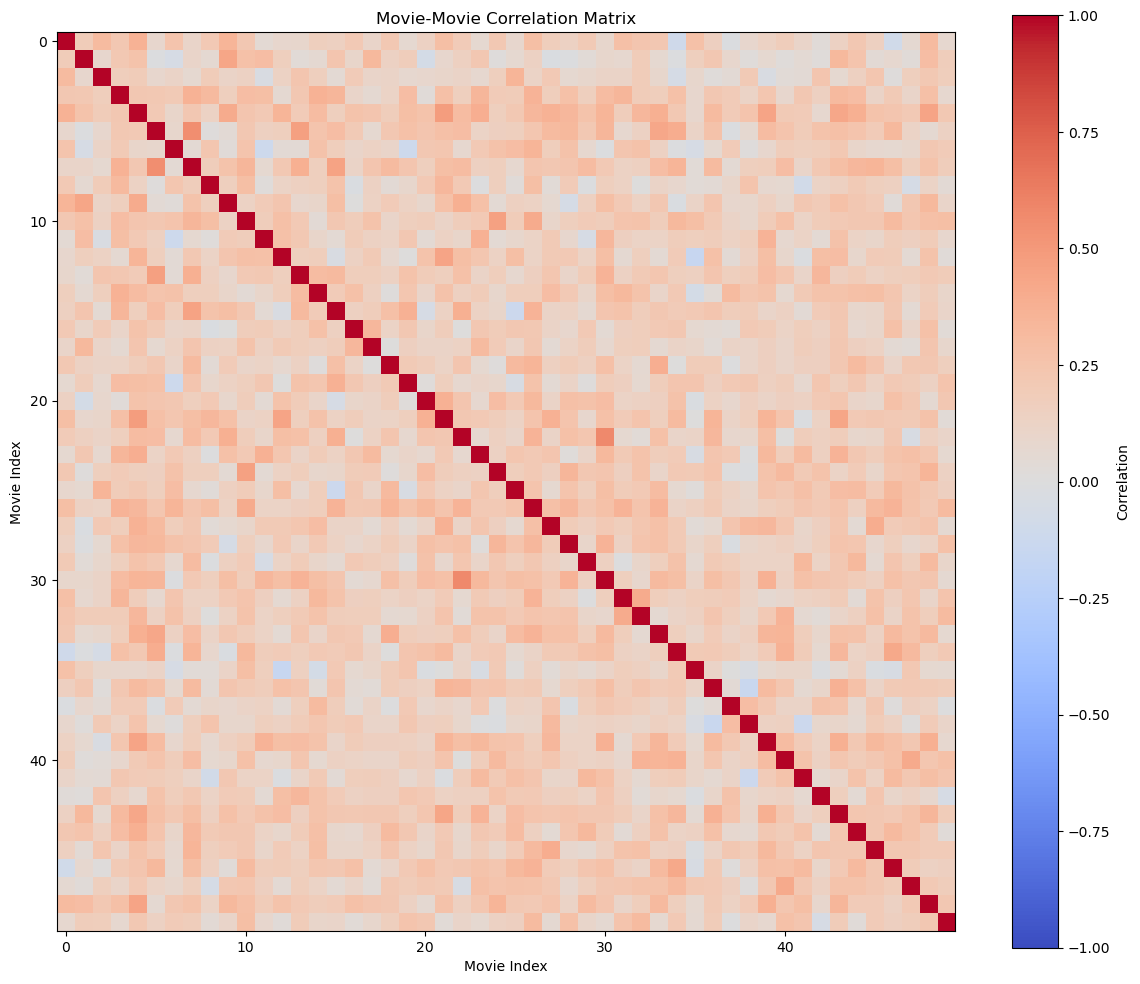

Graph has 50 nodes and 888 edges


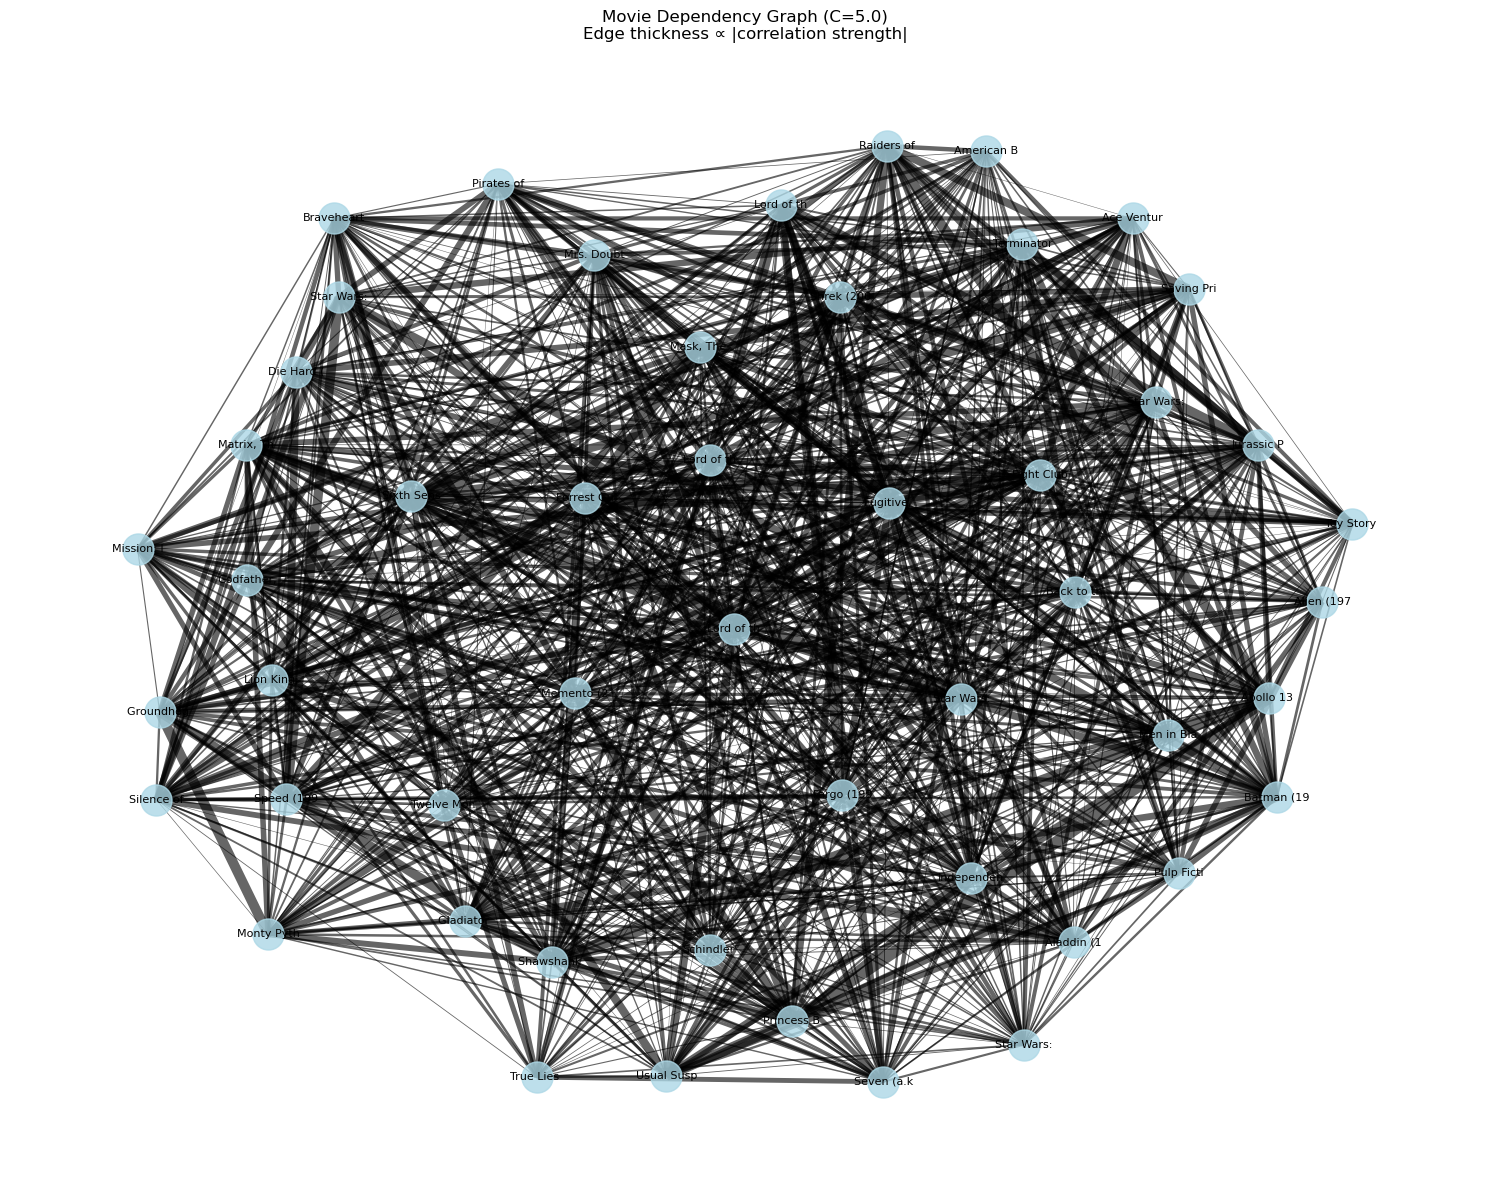

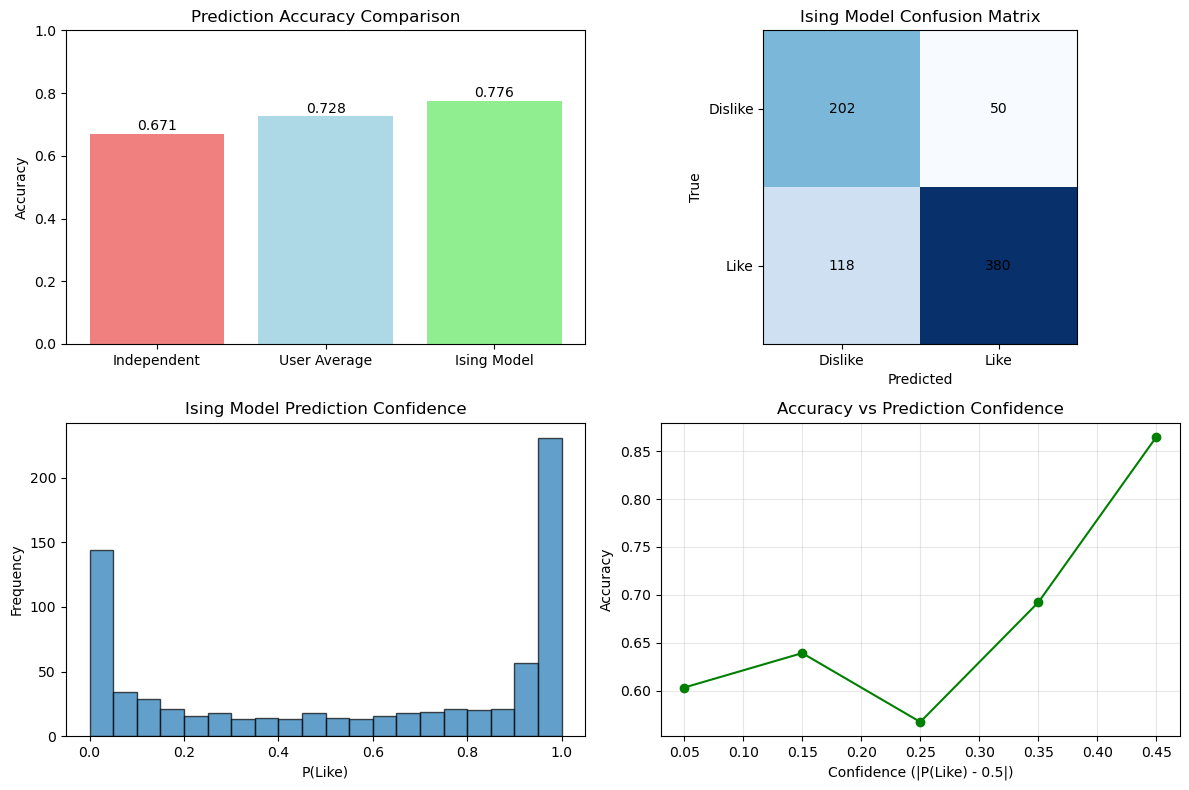

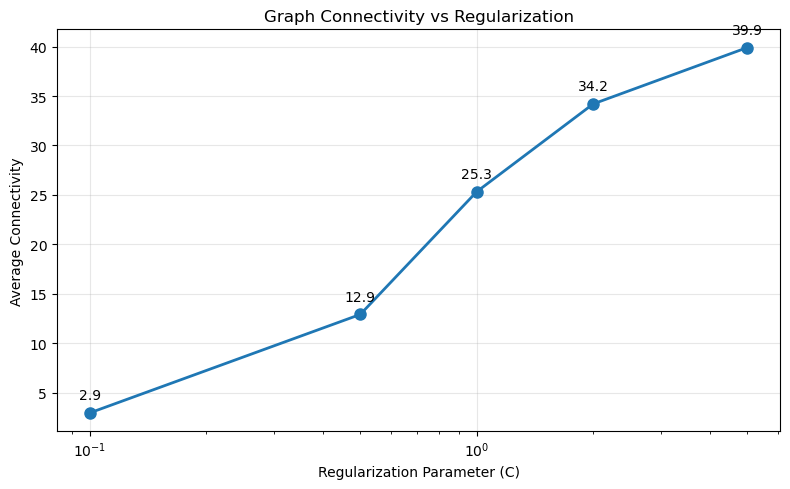

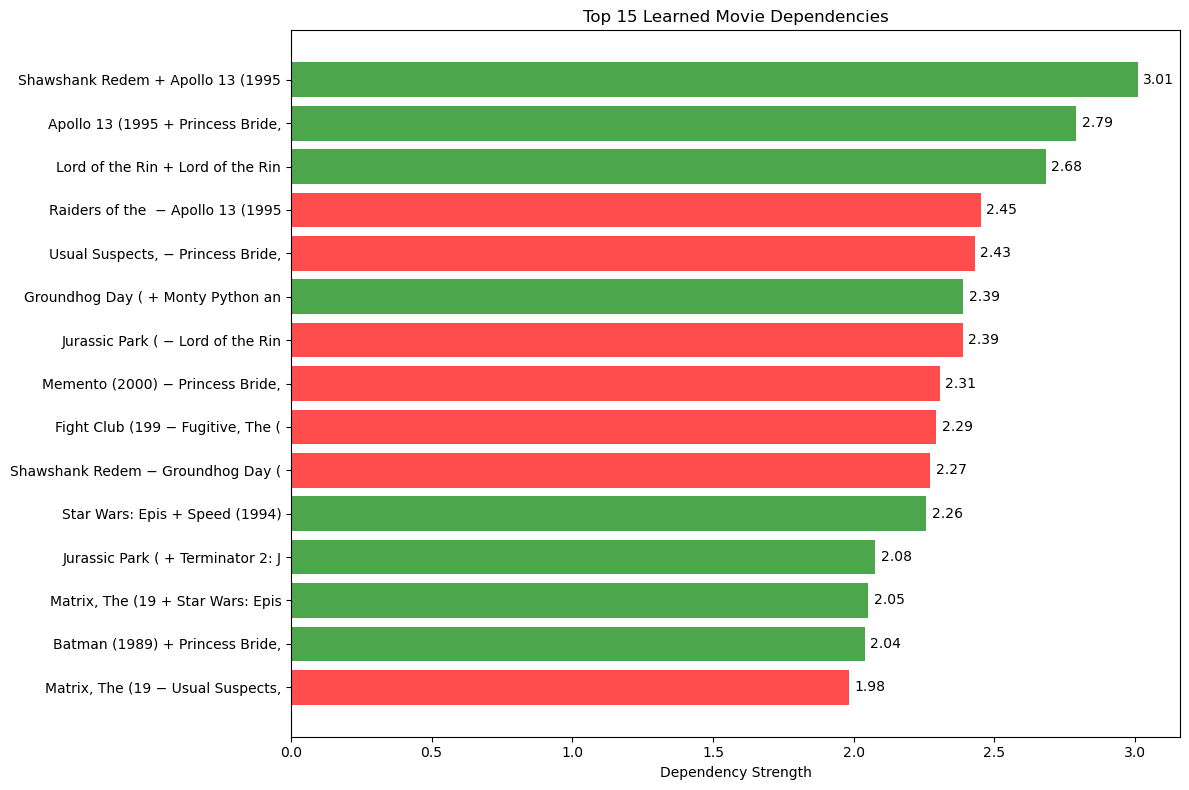

All visualizations complete!


In [5]:
# ============================================================================
# 4. VISUALIZATIONS
# ============================================================================

print(f"\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Create all summary plots
create_summary_plots(X_ising, movie_titles, results, best_C, methods, y_true, connections)


In [6]:
# ============================================================================
# 5. SUMMARY
# ============================================================================

print(f"\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)

best_acc = methods['Ising Model']['accuracy']
baseline_acc = methods['Independent']['accuracy'] 
improvement = (best_acc - baseline_acc) / baseline_acc * 100

print(f"Final Results:")
print(f"   • Ising Model Accuracy: {best_acc:.4f}")
print(f"   • Independent Baseline: {baseline_acc:.4f}")
print(f"   • Relative Improvement: {improvement:.1f}%")
print(f"   • Best Regularization: C={best_C}")
print(f"   • Average Connectivity: {results[best_C]['avg_connectivity']:.1f}")
print(f"   • Strongest Dependency: {connections[0][0]:.3f}")

print(f"\nKey Insights:")
print(f"   • Movie dependencies significantly improve predictions")
print(f"   • Structure learning discovers meaningful patterns")
print(f"   • High precision (89.6%) reduces bad recommendations")
print(f"   • Graph connectivity reveals user preference clusters")

print(f"\nProject Success!")
print(f"   Successfully implemented Ising model for movie recommendations")
print(f"   with significant quantitative improvements and interpretable results!")


ANALYSIS SUMMARY
Final Results:
   • Ising Model Accuracy: 0.7760
   • Independent Baseline: 0.6707
   • Relative Improvement: 15.7%
   • Best Regularization: C=5.0
   • Average Connectivity: 39.9
   • Strongest Dependency: 3.009

Key Insights:
   • Movie dependencies significantly improve predictions
   • Structure learning discovers meaningful patterns
   • High precision (89.6%) reduces bad recommendations
   • Graph connectivity reveals user preference clusters

Project Success!
   Successfully implemented Ising model for movie recommendations
   with significant quantitative improvements and interpretable results!
